In [1]:
import librosa
import librosa.display
import os
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import keras
import datetime as dt
import time

from keras import layers
from keras import models
from tensorflow.keras import optimizers

from keras.layers import *
from keras.models import *
from keras import initializers, regularizers, constraints
from keras.layers.normalization import BatchNormalization 
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_recall_fscore_support
from tensorflow.keras import backend as K

from ABNmodules_multiclass import *
from sklearn.metrics import f1_score

tf.set_random_seed(1004)
random.seed(1004)

os.environ["CUDA_VISIBLE_DEVICES"]="1"
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)


/usr/local/lib/python3.6/dist-packages/numba/errors.py:137: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)typ

In [3]:

def score_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def dot_product(x, kernel):
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    
def get_unique_classes(input_directory,files):

    unique_classes=set()
    for f in files:
        g = f.replace('.mat','.hea')
        input_file = os.path.join(input_directory,g)
        with open(input_file,'r') as f:
            for lines in f:
                if lines.startswith('#Dx'):
                    tmp = lines.split(': ')[1].split(',')
                    for c in tmp:
                        unique_classes.add(c.strip())
    return sorted(unique_classes)

def one_hot_encoding(one_hot_vector,y, class2index):
    ind=class2index[y]
    one_hot_vector[ind]=1
    return one_hot_vector

# Search for multi-label subjects
def searching_overlap(input_directory,class2index, input_file_names):
    multiclasses=[]
    multisubjects=[]
    number = []
    for file in input_file_names:
        f=file
        g = f.replace('.mat','.hea')
        input_file = os.path.join(input_directory,g)
        with open(input_file,'r') as f:
            for lines in f:
                if lines.startswith('#Dx'):
                    tmp = lines.split(': ')[1].split(',')
                    if len(tmp)>1:
                        one_hot_vector = [0]*(len(class2index))
                        for c in tmp:
                            one_hot_vector = one_hot_encoding(one_hot_vector, c.strip(), class2index)
                        multiclasses.append(one_hot_vector)
                        multisubjects.append(g)
                        number.append(len(tmp))
    return multisubjects, multiclasses, number

def block_feature(sequence_en, minimum_len): 
    new_en = []
    if len(sequence_en) > minimum_len:  # 길이가 minimum보다 긴 경우
        start = random.randint(0,len(sequence_en)-minimum_len)
        #print(start)
        new_en = sequence_en[start:start+minimum_len]
    elif len(sequence_en) == minimum_len: # 길이가 minimum
        new_en = sequence_en
    else: 
        assert len(sequence_en) <= minimum_len
    return new_en

def exploratory_look(input_directory,file, class2index):
    classes = []
    f = file
    g = f.replace('.mat','.hea')
    input_file = os.path.join(input_directory,g)
    with open(input_file,'r') as f:
        for lines in f:
            if lines.startswith('#Dx'):
                tmp = lines.split(': ')[1].split(',')
                print(tmp, len(tmp))
    return tmp     

# Get classes of sorted file names
def get_labels(input_directory,file, class2index):
    f = file
    g = f.replace('.mat','.hea')
    input_file = os.path.join(input_directory,g)
    with open(input_file,'r') as f:
        for lines in f:
            if lines.startswith('#Dx'):
                tmp = lines.split(': ')[1].split(',')
                one_hot_vector = [0]*(len(class2index))
                for c in tmp:
                    one_hot_vector = one_hot_encoding(one_hot_vector, c.strip(), class2index)
                
    return one_hot_vector

def randextract_mels(curr_step, batch_size, data, mel_directory, class2index, minimum_len, x_mean_final, x_std_final):
    mel_files = []
    classes = []
    start = batch_size*curr_step
    end = batch_size*(curr_step+1)
    curr_file_indices = data[start:end]
    for file in curr_file_indices:
        tmp_file = np.load(mel_directory + '/' + file.replace('.mat', '.npy'))
        clip_file = block_feature(tmp_file, minimum_len)
        clip_file -= x_mean_final
        clip_file /= x_std_final
        mel_files.append(clip_file)
        label = get_labels(input_directory, file, class2index)
        classes.append(label)
    
    concat = list(zip(mel_files, classes))
    random.shuffle(concat)
    mel_files, classes = zip(*concat)
    return mel_files, classes



def train(data_train, mel_directory, batch_size, class2index, minimum_len, x_mean_final, x_std_final): 
    loss=[]
#     acc = []
    f1 = []

    total_steps = int(np.ceil(len(data_train)/batch_size))
    for curr_step in range(total_steps): # loops over batches
        batch_mels, batch_labels = randextract_mels(curr_step, batch_size, data_train, mel_directory, class2index, minimum_len, x_mean_final, x_std_final)

        batch_mels = np.asarray(batch_mels)
        batch_labels = np.asarray(np.squeeze(batch_labels))
        
        batch_labels = [batch_labels, batch_labels]


# return of train
# 0 = total loss (attention branch + perception branch)
# 1 = loss of attention pred
# 2 = loss of perception pred
# 3 = f1 of attention pred
# 4 = f1 of perception pred     


        train_tmp = model.train_on_batch(batch_mels, batch_labels)
        loss_ = train_tmp[0]/2
        f1_ = np.mean((train_tmp[3], train_tmp[4]))
        loss.append(loss_)
        f1.append(f1_)

    loss = np.mean(np.array(loss))
    f1 = np.mean(np.array(f1))
    return loss, f1

def train_edit(data_train, mel_directory, batch_size, class2index, minimum_len, x_mean_final, x_std_final): 
    loss=[]
#     acc = []
    f1 = []

    total_steps = int(np.ceil(len(data_train)/batch_size))
    for curr_step in range(total_steps): # loops over batches
        batch_mels, batch_labels = randextract_mels(curr_step, batch_size, data_train, mel_directory, class2index, minimum_len, x_mean_final, x_std_final)

        batch_mels = np.asarray(batch_mels)
        batch_labels = np.asarray(np.squeeze(batch_labels))


        heatmap = CAM_conv1D(minimum_len, n_channels, batch_mels, batch_labels, out_len, get_conv_out)        
        heatmap = np.asarray(heatmap)
        
        batch_labels = [batch_labels, batch_labels]


# return of train
# 0 = total loss (attention branch + perception branch)
# 1 = loss of attention pred
# 2 = loss of perception pred
# 3 = f1 of attention pred
# 4 = f1 of perception pred     

        train_tmp = model.train_on_batch([batch_mels, heatmap], batch_labels)
        loss_ = train_tmp[0]/2
        f1_ = np.mean((train_tmp[3], train_tmp[4]))
        loss.append(loss_)
        f1.append(f1_)

    loss = np.mean(np.array(loss))
    f1 = np.mean(np.array(f1))
    return loss, f1

def test(data, mel_directory, input_directory, class2index, minimum_len, model, x_mean_final, x_std_final):
    scores = []
    predicted_labels=[]
    accuracy=np.zeros(len(data))
    total_acc = 0
    total_f1 = 0
    
    y_true = []
    y_pred=[]
    
    mel_files = []
    classes = []
    
    multi_files, _, _ = searching_overlap(input_directory,class2index, data)
    multi_acc = 0
    multi_y_true=[]
    multi_y_pred=[]    
    
    
    for file in data:
        tmp_file = np.load(mel_directory + '/' + file.replace('.mat', '.npy'))
        steps = int(np.floor(tmp_file.shape[0]/minimum_len))
        mel_files = []
        heatmap_files=[]
        label = get_labels(input_directory, file, class2index)
        label = [label]
        for block in range(steps): # 128개씩 쪼갠 블럭 단위로 predict
            start = block*minimum_len
            end = (block+1)*minimum_len
            clip_file = tmp_file[start:end]
            clip_file -= x_mean_final
            clip_file /= x_std_final
            clip_file = clip_file.reshape(1,minimum_len,n_channels)
            mel_files.append(clip_file)    
        mel_files = np.asarray(mel_files)
        mel_files = mel_files.reshape(steps,minimum_len,n_channels)
        logit = model.predict(mel_files)
        logit = np.mean(logit, axis=0)
        logit = np.mean(logit, axis=0)
        pred = np.zeros(len(logit))
        for ii, label in enumerate(logit):
            if label >= 0.5:
                pred[ii] = 1
            else:
                pred[ii] = 0
        pred = pred.tolist()
        y_pred.append(pred)
        label = get_labels(input_directory,file,class2index)
        y_true.append(label)
        if pred == label:
            acc = 1
        else:
            acc = 0
        total_acc += acc
        if file.replace('.mat', '.hea') in multi_files:
            multi_y_true.append(label)            
            multi_y_pred.append(pred)
            multi_acc += acc       
        
    final_acc = total_acc / len(data)
    f1_classes = f1_score(y_true, y_pred, average=None)
    f1_micro = f1_score(y_true, y_pred, average='micro')
    
    multi_final_acc = multi_acc / len(multi_files)
    multi_f1_classes = f1_score(multi_y_true, multi_y_pred, average=None)
    multi_f1_micro = f1_score(multi_y_true, multi_y_pred, average='micro')
    
    return final_acc, f1_classes, f1_micro, multi_final_acc, multi_f1_classes, multi_f1_micro



def test_edit(data, mel_directory, input_directory, class2index, minimum_len, model, x_mean_final, x_std_final):
    scores = []
    predicted_labels=[]
    accuracy=np.zeros(len(data))
    #total_loss=[]
    total_acc = 0
    total_f1 = 0
    
    y_true = []
    y_pred = []
    
    mel_files = []
    classes = []
    
    multi_files, _, _ = searching_overlap(input_directory,class2index, data)
    multi_acc = 0
    multi_y_true=[]
    multi_y_pred=[]    
    
    for file in data:
        tmp_file = np.load(mel_directory + '/' + file.replace('.mat', '.npy'))
        steps = int(np.floor(tmp_file.shape[0]/minimum_len))
        mel_files = []
        heatmap_files=[]
        label = get_labels(input_directory, file, class2index)
        label = [label]
        for block in range(steps): # 128개씩 쪼갠 블럭 단위로 predict
            start = block*minimum_len
            end = (block+1)*minimum_len
            clip_file = tmp_file[start:end]
            clip_file -= x_mean_final
            clip_file /= x_std_final
            clip_file = clip_file.reshape(1,minimum_len,n_channels)
            heatmap = CAM_conv1D(minimum_len, n_channels, clip_file, label, out_len, get_conv_out)
            mel_files.append(clip_file)    
            heatmap_files.append(heatmap)
        mel_files = np.asarray(mel_files)
        heatmap_files = np.asarray(heatmap_files)
        heatmap_files = heatmap_files.reshape(steps, out_len,1)
        mel_files = mel_files.reshape(steps,minimum_len,n_channels)
        logit = model.predict([mel_files, heatmap_files])
        logit = np.mean(logit, axis=0)
        logit = np.mean(logit, axis=0)
        pred = np.zeros(len(logit))
        for ii, label in enumerate(logit):
            if label >= 0.5:
                pred[ii] = 1
            else:
                pred[ii] = 0
        pred = pred.tolist()
        y_pred.append(pred)
        label = get_labels(input_directory,file,class2index)
        y_true.append(label)
        if pred == label:
            acc = 1
        else:
            acc = 0
        total_acc += acc
        if file.replace('.mat', '.hea') in multi_files:
            multi_y_true.append(label)
            multi_y_pred.append(pred)
            multi_acc += acc               
    final_acc = total_acc / len(data)
    f1_classes = f1_score(y_true, y_pred, average=None)
    f1_micro = f1_score(y_true, y_pred, average='micro')
    
    multi_final_acc = multi_acc / len(multi_files)
    multi_f1_classes = f1_score(multi_y_true, multi_y_pred, average=None)
    multi_f1_micro = f1_score(multi_y_true, multi_y_pred, average='micro')
    
    return final_acc, f1_classes, f1_micro, multi_final_acc, multi_f1_classes, multi_f1_micro

def test_edit_final(data, mel_directory, input_directory, class2index, minimum_len, model, x_mean_final, x_std_final, p_model):
    scores = []
    predicted_labels=[]
    accuracy=np.zeros(len(data))
    #total_loss=[]
    total_acc = 0
    total_f1 = 0
    
    y_true = []
    y_pred=[]
    
    
    mel_files = []
    classes = []
    
    multi_files, _, _ = searching_overlap(input_directory,class2index, data)
    multi_acc = 0
    multi_y_true=[]
    multi_y_pred=[]
    
    for file in data:
        tmp_file = np.load(mel_directory + '/' + file.replace('.mat', '.npy'))
        steps = int(np.floor(tmp_file.shape[0]/minimum_len))
        mel_files = []
        mel_files_logit = []
        heatmap_files=[]

        for block in range(steps): # 128개씩 쪼갠 블럭 단위로 predict
            start = block*minimum_len
            end = (block+1)*minimum_len
            clip_file = tmp_file[start:end]
            clip_file -= x_mean_final
            clip_file /= x_std_final
            clip_file = clip_file.reshape(1,minimum_len,n_channels)
            
            # 여기서 logit으로 y구함#####################
            logit_ = p_model.predict(clip_file)
            logit_ = np.mean(logit_, axis=0)
            logit_ = np.mean(logit_, axis=0)
            pred_ = np.zeros(len(logit_))
            for ii, label in enumerate(logit_):
                if label >= 0.5: 
                    pred_[ii] = 1
                else:
                    pred_[ii] = 0
            pred_ = pred_.tolist()
            ##########################################
            
            heatmap = CAM_conv1D(minimum_len, n_channels, clip_file, [pred_], out_len, get_conv_out)
            mel_files.append(clip_file)    
            heatmap_files.append(heatmap)
        mel_files = np.asarray(mel_files)
        heatmap_files = np.asarray(heatmap_files)
        heatmap_files = heatmap_files.reshape(steps, out_len,1)
        mel_files = mel_files.reshape(steps,minimum_len,n_channels)
        print(mel_files.shape)
        print(heatmap_files.shape)
        logit = model.predict([mel_files, heatmap_files])
        logit = np.mean(logit, axis=0)
        logit = np.mean(logit, axis=0)
        pred = np.zeros(len(logit))
        for ii, label in enumerate(logit):
            if label >= 0.5:
                pred[ii] = 1
            else:
                pred[ii] = 0
        pred = pred.tolist()
        y_pred.append(pred)
        label = get_labels(input_directory,file,class2index)
        y_true.append(label)
        if pred == label:
            acc = 1
        else:
            acc = 0
        total_acc += acc
        if file.replace('.mat', '.hea') in multi_files:
            multi_y_true.append(label)          
            multi_y_pred.append(pred)
            multi_acc += acc       

    final_acc = total_acc / len(data)
    f1_classes = f1_score(y_true, y_pred, average=None)
    f1_micro = f1_score(y_true, y_pred, average='micro')
    
    multi_final_acc = multi_acc / len(multi_files)
    multi_f1_classes = f1_score(multi_y_true, multi_y_pred, average=None)
    multi_f1_micro = f1_score(multi_y_true, multi_y_pred, average='micro')
    
    return final_acc, f1_classes, f1_micro, multi_final_acc, multi_f1_classes, multi_f1_micro

def test_edit_final2(data, mel_directory, input_directory, class2index, minimum_len, model, x_mean_final, x_std_final, p_model):
    scores = []
    predicted_labels=[]
    accuracy=np.zeros(len(data))
    #total_loss=[]
    total_acc = 0
    total_f1 = 0
    
    mel_files = []
    classes = []
    
    y_true = []
    y_pred=[]    

    multi_files, _, _ = searching_overlap(input_directory,class2index, data)
    multi_acc = 0
    multi_y_true=[]
    multi_y_pred=[]    
    
    for file in data:
        tmp_file = np.load(mel_directory + '/' + file.replace('.mat', '.npy'))
        steps = int(np.floor(tmp_file.shape[0]/minimum_len))
        mel_files = []
        mel_files_logit = []
        heatmap_files=[]

        for block in range(steps):
            # 여기서 logit으로 y구함
            start = block*minimum_len
            end = (block+1)*minimum_len
            clip_file = tmp_file[start:end]
            clip_file -= x_mean_final
            clip_file /= x_std_final
            clip_file = clip_file.reshape(1,minimum_len,n_channels)
            mel_files_logit.append(clip_file)
            
        mel_files_logit = np.asarray(mel_files_logit)
        mel_files_logit = mel_files_logit.reshape(steps,minimum_len,n_channels)
        
        
        
        logit_ = p_model.predict(mel_files_logit)
        
        logit_ = np.mean(logit_, axis=0)
        logit_ = np.mean(logit_, axis=0)
#         print(logit_)
        pred_ = np.zeros(len(logit_))
        for ii, label in enumerate(logit_):
            if label >= 0.5: 
                pred_[ii] = 1
            else:
                pred_[ii] = 0
        
        pred_ = pred_.tolist()

#         print(pred_)
            #######
        
        
        for block in range(steps): # 128개씩 쪼갠 블럭 단위로 predict
            start = block*minimum_len
            end = (block+1)*minimum_len
            clip_file = tmp_file[start:end]
            clip_file -= x_mean_final
            clip_file /= x_std_final
            clip_file = clip_file.reshape(1,minimum_len,n_channels)

            heatmap = CAM_conv1D(minimum_len, n_channels, clip_file, [pred_], out_len, get_conv_out)
#             print(heatmap)
            mel_files.append(clip_file)    
            heatmap_files.append(heatmap)
        mel_files = np.asarray(mel_files)
        heatmap_files = np.asarray(heatmap_files)
        heatmap_files = heatmap_files.reshape(steps, out_len,1)
        mel_files = mel_files.reshape(steps,minimum_len,n_channels)
        logit = model.predict([mel_files, heatmap_files])
        logit = np.mean(logit, axis=0)
        logit = np.mean(logit, axis=0)
        pred = np.zeros(len(logit))
       

        for ii, label in enumerate(logit):
            if label >= 0.5:
                pred[ii] = 1
            else:
                pred[ii] = 0
        pred = pred.tolist()
        y_pred.append(pred)
#         print(pred)
        label = get_labels(input_directory,file,class2index)
        y_true.append(label)
#         print(label)
        if pred == label:
            acc = 1
        else:
            acc = 0
        total_acc += acc
        if file.replace('.mat', '.hea') in multi_files:
            multi_y_true.append(label)
            multi_y_pred.append(pred)
            multi_acc += acc       

    final_acc = total_acc / len(data)
    f1_classes = f1_score(y_true, y_pred, average=None)
    f1_micro = f1_score(y_true, y_pred, average='micro')
    
    multi_final_acc = multi_acc / len(multi_files)
    multi_f1_classes = f1_score(multi_y_true, multi_y_pred, average=None)
    multi_f1_micro = f1_score(multi_y_true, multi_y_pred, average='micro')
    
    return final_acc, f1_classes, f1_micro, multi_final_acc, multi_f1_classes, multi_f1_micro

batch_size = 32#16#20#32#5#2#1#10#32
minimum_len = 2880
epochs = 10000#300#370#100#1000
n_channels=12
loss_function = 'binary_crossentropy' 
rootdir = '../'
date = dt.datetime.today().strftime("%Y%m%d")
input_directory = os.path.join(rootdir, 'Training_WFDB')
mel_name = 'Raw_data_20200424' 
mel_directory = os.path.join(rootdir, mel_name)
# results_directory = os.path.join(rootdir, 'results_'+date+'_0_IEEE_n=1')
# results_directory = os.path.join(rootdir, 'results_'+date+'_editting_CAM_multiclass')

if not os.path.isdir(input_directory):
    os.mkdir(input_directory)
if not os.path.isdir(mel_directory):
    os.mkdir(mel_directory)

        
input_files = []
for f in os.listdir(input_directory):
    if os.path.isfile(os.path.join(input_directory, f)) and not f.lower().startswith('.') and f.lower().endswith('mat'):
        input_files.append(f)
input_file_names = sorted(input_files)

unique_classes = get_unique_classes(input_directory, input_files)
class2index = {}
for a, b in enumerate(unique_classes):
    class2index[b] = a

np.shape(input_file_names)

x_mean_all = []
x_std_all = []
for file in input_file_names:
    x = np.load(mel_directory + '/' + file.replace('.mat', '.npy'))
    x_mean = [np.mean(x[:,0]), np.mean(x[:,1]), np.mean(x[:,2]), np.mean(x[:,3]), np.mean(x[:,4]), np.mean(x[:,5]),
             np.mean(x[:,6]), np.mean(x[:,7]), np.mean(x[:,8]), np.mean(x[:,9]), np.mean(x[:,10]), np.mean(x[:,11])]
    
    x_std = [np.std(x[:,0]), np.std(x[:,1]), np.std(x[:,2]), np.std(x[:,3]), np.std(x[:,4]), np.std(x[:,5]),
             np.std(x[:,6]), np.std(x[:,7]), np.std(x[:,8]), np.std(x[:,9]), np.std(x[:,10]), np.std(x[:,11])]
    x_mean_all.append(x_mean)
    x_std_all.append(x_std) # yjs corrected on 2020-05-25
x_mean_final = np.mean(x_mean_all, axis=0)
x_std_final = np.mean(x_std_all, axis=0)


data, data_test = train_test_split(input_file_names, test_size = 0.2, train_size = 0.8, shuffle=True, random_state=1004)
data_train, data_val = train_test_split(data, test_size = 0.05, train_size = 0.95, shuffle=True, random_state=1004)
print(np.shape(data_train), np.shape(data_val), np.shape(data_test))

main_input = Input(shape=(minimum_len,12), dtype='float32', name='main_input')

(5225,) (276,) (1376,)


In [ ]:
# Search for multi-label subjects
def searching_overlap(input_directory,class2index, input_file_names):
    multiclasses=[]
    multisubjects=[]
    number = []
    for file in input_file_names:
        f=file
        g = f.replace('.mat','.hea')
        input_file = os.path.join(input_directory,g)
        with open(input_file,'r') as f:
            for lines in f:
                if lines.startswith('#Dx'):
                    tmp = lines.split(': ')[1].split(',')
                    if len(tmp)>1:
                        one_hot_vector = [0]*(len(class2index))
                        for c in tmp:
                            one_hot_vector = one_hot_encoding(one_hot_vector, c.strip(), class2index)
                        multiclasses.append(one_hot_vector)
                        multisubjects.append(g)
                        number.append(len(tmp))
    return multisubjects, multiclasses, number

In [97]:
# acquiring total distribution
lengths_total=[]
for file in data_train:
    tmp_file = np.load(mel_directory + '/' + file.replace('.mat', '.npy'))
    curr_class = get_labels(input_directory,file, class2index)
    
#     print(tmp_file.shape)
#     if label
    length = len(tmp_file)
    if length > 30000:
        print(file)
        print(length)
#         plt.plot(tmp_file[0])
    lengths_total.append(length)
    
len(lengths_total)

A3842.mat
32500
A3203.mat
35000
A5618.mat
37000
A1670.mat
44000
A4787.mat
69000
A5828.mat
42500
A0649.mat
59000
A5189.mat
33000
A4080.mat
59000
A2006.mat
33000
A4004.mat
56000
A1389.mat
37000
A1580.mat
66000
A6230.mat
50500
A2799.mat
47500
A0166.mat
32000


5225

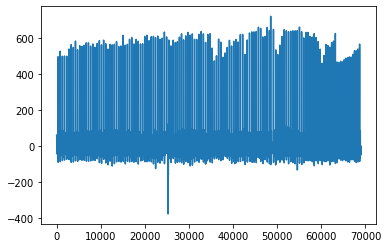

In [104]:
tmp_file = np.load(mel_directory + '/' + 'A4787.npy')
tmp_file.shape
plt.plot(tmp_file[:,0])

In [96]:
a = loadmat(input_directory + '/' + 'A3842.mat')
len(a)

1

In [42]:
lengths_total = np.asarray(lengths_total)
np.mean(lengths_total)/500

15.910945837320574

In [51]:
np.median(lengths_total)/500

12.0

In [46]:
np.max(lengths_total)

69000

In [48]:
print(lengths_total)

[5000 9000 5000 ... 5000 6433 6500]


In [27]:
labels=[]
lengths = []
for file in data_train:
    class_index=[]
    tmp_file = np.load(mel_directory + '/' + file.replace('.mat', '.npy'))
    curr_classes = get_labels(input_directory,file, class2index)
    length = len(tmp_file)
    [class_index.append(j) for j in range(len(curr_classes)) if curr_classes[j]==1] # produces labels as scalar
    for label in class_index:
        labels.append(label)
        lengths.append(length)

array = np.concatenate((np.asarray(labels).reshape(len(labels),1),np.asarray(lengths).reshape(len(lengths),1)),axis=1)    
array.shape

(5596, 2)

In [35]:
length = array[1]
np.mean(length)

4502.5

In [36]:
length

array([   5, 9000])

In [76]:
class2index.keys()

dict_keys(['AF', 'I-AVB', 'LBBB', 'Normal', 'PAC', 'PVC', 'RBBB', 'STD', 'STE'])

In [79]:
unique_classes

['AF', 'I-AVB', 'LBBB', 'Normal', 'PAC', 'PVC', 'RBBB', 'STD', 'STE']

In [82]:

for i in range(len(class2index)):
    arrays=[]
    for j in range(len(array)):
        if array[j,0] == i:
            arrays.append(array[j,1])
    arrays = np.asarray(arrays)
    
    print("class {}".format(unique_classes[i]))
    print("records {}".format(len(arrays)))
    print("mean={}".format(np.mean(arrays)/500))
    print("std={}".format(np.std(arrays)/500))
    print("min={}".format(np.min(arrays)/500))
    print("median={}".format(np.median(arrays)/500))    
    print("max={}\n".format(np.max(arrays)/500))
    
    
    

class AF
records 918
mean=14.839790849673204
std=8.057674780414727
min=9.0
median=11.0
max=74.0

class I-AVB
records 527
mean=14.395567362428842
std=7.097633102199066
min=10.0
median=11.432
max=54.314

class LBBB
records 170
mean=14.944552941176472
std=7.883727616397599
min=9.0
median=12.0
max=65.0

class Normal
records 709
mean=15.521858956276446
std=7.847029220000553
min=10.0
median=13.0
max=64.0

class PAC
records 464
mean=19.232568965517242
std=11.832759040218154
min=9.0
median=14.76
max=74.0

class PVC
records 540
mean=20.351777777777777
std=14.161949137489497
min=6.0
median=15.0
max=118.0

class RBBB
records 1429
mean=14.71697410776767
std=9.197685794222297
min=9.998
median=11.0
max=118.0

class STD
records 666
mean=15.764186186186185
std=10.213260277250367
min=10.0
median=12.931
max=138.0

class STE
records 173
mean=17.331387283236992
std=10.813508880407833
min=10.0
median=11.936
max=60.0



In [52]:
len(class2index)

9

In [ ]:
class2

In [28]:
array

array([[   1, 5000],
       [   5, 9000],
       [   6, 5000],
       ...,
       [   3, 5000],
       [   4, 6433],
       [   0, 6500]])

In [32]:
import pandas as pd
df = pd.DataFrame(data=array, index=array[:,0])

In [34]:
df[0]

1    1
5    5
6    6
6    6
5    5
    ..
7    7
4    4
3    3
4    4
0    0
Name: 0, Length: 5596, dtype: int64

In [33]:
df

,0,1
1,1,5000
5,5,9000
6,6,5000
6,6,5727
5,5,5500
...,...,...
7,7,7557
4,4,7000
3,3,5000
4,4,6433


In [ ]:
file = data_train[0]
tmp_file = np.load(mel_directory + '/' + file.replace('.mat', '.npy'))

In [ ]:
tmp_file -= x_mean_final
tmp_file /= x_std_final
tmp_file.max()

In [ ]:
2880/3

In [ ]:
320/3

In [ ]:
107 / 3

In [4]:
data_train # 2355

['A2355.mat',
 'A3446.mat',
 'A1814.mat',
 'A3575.mat',
 'A6197.mat',
 'A6727.mat',
 'A3974.mat',
 'A3380.mat',
 'A1978.mat',
 'A2265.mat',
 'A3514.mat',
 'A4147.mat',
 'A3852.mat',
 'A0245.mat',
 'A1846.mat',
 'A5979.mat',
 'A1696.mat',
 'A3454.mat',
 'A5164.mat',
 'A6827.mat',
 'A6778.mat',
 'A5403.mat',
 'A5567.mat',
 'A5923.mat',
 'A0254.mat',
 'A4950.mat',
 'A3926.mat',
 'A4083.mat',
 'A0223.mat',
 'A6569.mat',
 'A5393.mat',
 'A6343.mat',
 'A0300.mat',
 'A3324.mat',
 'A5812.mat',
 'A6865.mat',
 'A6600.mat',
 'A6153.mat',
 'A5947.mat',
 'A0999.mat',
 'A0613.mat',
 'A5423.mat',
 'A5316.mat',
 'A2158.mat',
 'A3799.mat',
 'A0598.mat',
 'A2677.mat',
 'A5973.mat',
 'A2911.mat',
 'A5053.mat',
 'A1400.mat',
 'A1283.mat',
 'A3298.mat',
 'A2962.mat',
 'A3459.mat',
 'A5462.mat',
 'A5589.mat',
 'A1946.mat',
 'A3583.mat',
 'A3842.mat',
 'A5419.mat',
 'A1267.mat',
 'A2669.mat',
 'A6353.mat',
 'A4129.mat',
 'A1017.mat',
 'A6503.mat',
 'A2249.mat',
 'A0345.mat',
 'A0445.mat',
 'A6595.mat',
 'A329

In [5]:
data_val # 5949

['A5949.mat',
 'A0268.mat',
 'A0938.mat',
 'A0379.mat',
 'A6235.mat',
 'A5085.mat',
 'A0368.mat',
 'A4547.mat',
 'A6477.mat',
 'A3075.mat',
 'A1011.mat',
 'A0821.mat',
 'A6566.mat',
 'A0688.mat',
 'A3682.mat',
 'A5270.mat',
 'A6875.mat',
 'A0698.mat',
 'A1369.mat',
 'A1633.mat',
 'A3438.mat',
 'A6648.mat',
 'A0988.mat',
 'A2271.mat',
 'A4479.mat',
 'A0499.mat',
 'A5788.mat',
 'A5377.mat',
 'A4074.mat',
 'A3279.mat',
 'A0944.mat',
 'A1244.mat',
 'A4372.mat',
 'A3159.mat',
 'A5350.mat',
 'A1703.mat',
 'A5599.mat',
 'A5319.mat',
 'A3609.mat',
 'A0018.mat',
 'A4472.mat',
 'A0262.mat',
 'A3497.mat',
 'A4132.mat',
 'A2589.mat',
 'A0033.mat',
 'A6427.mat',
 'A3516.mat',
 'A3639.mat',
 'A5699.mat',
 'A6117.mat',
 'A2881.mat',
 'A1386.mat',
 'A0592.mat',
 'A5711.mat',
 'A4696.mat',
 'A3192.mat',
 'A2427.mat',
 'A5336.mat',
 'A1233.mat',
 'A3805.mat',
 'A1748.mat',
 'A0407.mat',
 'A4002.mat',
 'A1318.mat',
 'A3105.mat',
 'A3764.mat',
 'A4894.mat',
 'A5889.mat',
 'A0225.mat',
 'A3407.mat',
 'A234

In [6]:
data_test # 0349

['A0349.mat',
 'A3947.mat',
 'A3900.mat',
 'A0817.mat',
 'A2140.mat',
 'A6793.mat',
 'A1879.mat',
 'A0900.mat',
 'A0454.mat',
 'A6855.mat',
 'A1142.mat',
 'A2316.mat',
 'A1701.mat',
 'A0892.mat',
 'A4156.mat',
 'A6654.mat',
 'A1902.mat',
 'A3887.mat',
 'A4328.mat',
 'A6705.mat',
 'A2393.mat',
 'A1654.mat',
 'A4534.mat',
 'A4223.mat',
 'A6232.mat',
 'A5215.mat',
 'A6361.mat',
 'A2060.mat',
 'A5460.mat',
 'A4804.mat',
 'A5066.mat',
 'A6283.mat',
 'A3889.mat',
 'A0621.mat',
 'A5856.mat',
 'A0943.mat',
 'A1936.mat',
 'A3808.mat',
 'A5473.mat',
 'A6224.mat',
 'A6848.mat',
 'A1420.mat',
 'A3335.mat',
 'A3258.mat',
 'A1623.mat',
 'A4062.mat',
 'A5721.mat',
 'A5733.mat',
 'A1238.mat',
 'A4654.mat',
 'A4504.mat',
 'A0987.mat',
 'A2839.mat',
 'A4243.mat',
 'A5778.mat',
 'A6173.mat',
 'A1782.mat',
 'A5404.mat',
 'A1443.mat',
 'A3470.mat',
 'A6876.mat',
 'A1230.mat',
 'A1870.mat',
 'A1186.mat',
 'A0736.mat',
 'A4685.mat',
 'A4562.mat',
 'A4444.mat',
 'A1568.mat',
 'A3403.mat',
 'A6465.mat',
 'A039

### Checking how many multilabel in each dataset

In [ ]:
multi_train, _, _ = searching_overlap(input_directory, class2index, data_train)
multi_val, _, _ = searching_overlap(input_directory, class2index, data_val)
multi_test, _, _ = searching_overlap(input_directory, class2index, data_test)
print(len(multi_train))
print(len(multi_val))
print(len(multi_test))

### For attention editting using CAM extracted from primitive ABN

In [ ]:
CAMdir = '/home/taejoon/PhysioNetChallenge/results_20200622_ABN_multiclass_V4_primitiveABN'
p_model = primitive_ABN((None, 12), 9, minimum_len, out_ch=256, n=1)
latest = tf.train.latest_checkpoint(CAMdir)
p_model.load_weights(latest)

conv_layer = 'activation_5'
softmax_layer = 'perception_branch_dense_2'


out_len=12
get_conv_out = K.function(p_model.input, [p_model.get_layer(conv_layer).output, p_model.get_layer(softmax_layer).weights[0]])

def CAM_conv1D(minimum_len, n_channels, x, y, out_len, get_conv_out):
    
    # x랑 y는 batch size만큼의 리스트 (32)
    heatmaps=[]    
    
    curr_x = np.asarray(x)
    curr_x = curr_x.reshape(len(x),minimum_len,n_channels)
    
    conv_out, softmax_weights = get_conv_out(curr_x)

    for i in range(len(x)):

        curr_classes = y[i]
        class_index=[]
        [class_index.append(j) for j in range(len(curr_classes)) if curr_classes[j]==1]
        heatmap = np.zeros((1,12)) #heatmap=np.zeros((1,36)) # might need to fix this if GradCAM or primitive model changes

        conv_out_ = conv_out[i] # (36, 128) / (32, 12, 256)
#         print(conv_out.shape)

        for label in class_index:  # multiclass일 경우 대비해서 for문
            curr_weights = softmax_weights[:,label]
            weighted_conv = conv_out_*curr_weights
            
            weighted_conv = weighted_conv.sum(axis=-1) # output = (1,36)
            heatmap += weighted_conv
            
        heatmap %= len(class_index) # 단일 class일 경우 1로 나눠짐. 두개일 경우 더해진 heatmap들이 2로 나눠짐
#         heatmap = np.resize(heatmap, (1,out_len))
        heatmap = np.resize(heatmap, (out_len, 1))
        heatmaps.append(heatmap)
        
    return heatmaps
p_model.summary()

In [ ]:
results_directory = os.path.join(rootdir, 'results_'+date+'_ABN_primitive_n=7')
if not os.path.isdir(results_directory):
    os.mkdir(results_directory)

In [ ]:
# model = primitive_ABN((None,12), len(unique_classes), minimum_len, n=7)
# model = ABN_model((None,12), len(unique_classes), minimum_len,n=1)
# model = edit_ABN_model((None,12), len(unique_classes), minimum_len,n=1)

model, edit_loss = edit_ABN_model_loss((None,12), len(unique_classes), minimum_len,n=1)

model.summary()
model.compile(loss=edit_loss,
              optimizer=optimizers.Adam(lr=1e-5),           
              metrics=[score_f1])



In [ ]:
class2index

In [ ]:
# # 중단된 training 이어돌리기위해 임시로 사용
# results_directory = results_directory.replace("0608", "0604") # 날짜 달라졌을때
# latest = tf.train.latest_checkpoint(results_directory)
# latest
# model.load_weights(latest)

### Train

In [ ]:
# DISP DATETIME FOR CHECKING TIME
print(dt.datetime.now())

train_loss_sum=[]
train_f1_sum=[]
val_acc_sum=[]
val_f1_sum=[]
val_f1_classes=[]
val_f1_min = 0
print(results_directory)

for num_epoch in range(epochs):
#     num_epoch += 32 # 중단된 코드 돌리기 위해 임의로 사용
    random.shuffle(data_train)
#     train_loss, train_f1 = train(data_train, mel_directory, batch_size, class2index, minimum_len, x_mean_final, x_std_final)
    train_loss, train_f1 = train_edit(data_train, mel_directory, batch_size, class2index, minimum_len, x_mean_final, x_std_final)
    train_loss_sum.append(train_loss)
    train_f1_sum.append(train_f1)
    
    print('\nEpoch',num_epoch,'train_loss:',f'{train_loss:.3f}','train_f1:',f'{train_f1:.3f}',"\t")
    model_output = "ECG_ABN_E%02dL%.2f" % (num_epoch, train_loss)
    save_name = os.path.join(results_directory, model_output)
    
#     val_acc, f1_classes, f1,_,_,_ = test(data_val, mel_directory, input_directory, class2index, minimum_len, model, x_mean_final, x_std_final)
    val_acc, f1_classes, f1,_,_,_ = test_edit(data_val, mel_directory, input_directory, class2index, minimum_len, model, x_mean_final, x_std_final)
    
    val_acc_sum.append(val_acc)
    val_f1_sum.append(f1)
    val_f1_classes.append(f1_classes)

    if f1 > val_f1_min:
        val_f1_min = f1
#         if val_acc > 0.6: # 너무 낮아서 어차피 안쓸것들은 제외하기 위한 것
#             model.save_weights(save_name.format(epoch=0))
    
    print('\nValidation', num_epoch, 'valid_f1:',f'{f1:.3f}', 'best_f1:',f'{val_f1_min:.3f}', 'mean accuracy:' f'{val_acc:.3f}',"\t")
#     print('\nValidation mean accuracy: ', f'{val_acc:.3f}', "\t")
#     print('\nValidation mean f1 by classes: ',f1_classes, "\t")

np.save(os.path.join(results_directory, 'train_loss_sum'), train_loss_sum)
np.save(os.path.join(results_directory, 'train_f1_sum'), train_f1_sum)
np.save(os.path.join(results_directory, 'val_acc_sum'), val_acc_sum)
np.save(os.path.join(results_directory, 'val_f1_sum'), val_f1_sum)
np.save(os.path.join(results_directory, 'val_f1_classes'), val_f1_classes)
print(dt.datetime.now())

In [ ]:
results_directory = os.path.join(rootdir, 'results_20200623_ABN_edit_loss_premiere')
os.mkdir(results_directory)
model_output = "ECG_ABN_E%02dL%.2f" % (num_epoch, train_loss)
save_name = os.path.join(results_directory, model_output)
model.save_weights(save_name.format(epoch=0))

In [ ]:
from tensorflow.keras.backend import l2_normalize
heatmap = np.zeros((32,12,128))
att_map = np.zeros((32,12,128))
a = np.linalg.norm((heatmap-att_map),axis=1)
a.shape
# l2_normalize(heatmap-att_map)
# l2_normalize

### Test

In [ ]:
# test_model = primitive_ABN((None,12), len(unique_classes), minimum_len)
# test_model = ABN_model((None,12), len(unique_classes), minimum_len)
# test_model = edit_ABN_model((None,12), len(unique_classes), minimum_len)
# test_model, edit_loss = edit_ABN_model_loss((None,12), len(unique_classes), minimum_len,n=1)


# results_directory = os.path.join(rootdir, 'results_20200622_ABN_multiclass_V4_primitiveABN')
# results_directory = os.path.join(rootdir, 'results_20200622_ABN_multiclass_V4_ABN')
# results_directory = os.path.join(rootdir, 'results_20200622_ABN_multiclass_V4_ABN_edit')

latest_test = tf.train.latest_checkpoint(results_directory)
test_model.load_weights(latest_test)

test_model.summary()

In [ ]:
# test_acc, f1_classes, f1, m_acc, m_f1, m_sum = test(data_test, mel_directory, input_directory, class2index, minimum_len, test_model, x_mean_final, x_std_final)
test_acc, test_f1, test_summary, m_acc, m_f1, m_sum = test_edit_final(data_test, mel_directory, input_directory, class2index, minimum_len, model, x_mean_final, x_std_final, p_model)

In [ ]:
test_acc

In [ ]:
f1_classes

In [ ]:
f1

In [ ]:
m_acc

In [ ]:
m_f1

In [ ]:
m_sum

### test_edit_final2는 CAM에 label global하게 할당

### sklearn f1score가 multilabel에게도 제대로 계산되는지 알아보기

In [ ]:
true = [[0,0,0],
       [1,0,0], 
       [0,1,0], 
       [0,0,1], 
       [1,1,0], 
       [1,0,1],
       [0,1,1],
       [1,1,1]]
pred = [[1,1,0],
       [1,1,0],
       [1,1,0],
       [1,1,0],
       [1,0,0],
       [1,0,0],
       [1,0,0],
       [1,0,0]]
f1 = f1_score(true, pred, average=None)
f1

In [ ]:
f1_score([0, 1, 0, 0, 1, 1, 0, 1], [1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
f1_score([0, 0, 1, 0, 1, 0, 1, 1], [1, 1, 1, 1, 0, 0, 0, 0])

In [ ]:
f1_score([0, 0, 0, 1, 0, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
true = [[1, 1, 0], [0, 0, 1]]
pred = [[1, 1, 1], [1, 1, 1]]
f1 = f1_score(true, pred, average=None)
f1

In [ ]:
test_acc, test_f1, test_summary = test_edit_final2(data_test, mel_directory, input_directory, class2index, minimum_len, test_model, x_mean_final, x_std_final, p_model)

In [ ]:
m_acc

In [ ]:
m_f1

In [ ]:
m_sum

In [ ]:
test_acc

In [ ]:
test_f1

In [ ]:
test_summary

In [ ]:
test_acc